In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import pandas as pd
from scipy.optimize import curve_fit
dirname = os.path.dirname("__file__")

# 6.2 Observing Rayleigh Fractionation

In [3]:
# Loading all data
#fileloc_rayleigh = "C:/Users/fexfl/Documents/GitHub/FP/F55/twvia_2023-01-08_f0000.txt"

fileloc_rayleigh = os.path.join(dirname, 'twvia_2023-01-08_f0000.txt')

# Loading time seperately as a string
time = np.loadtxt(fileloc_rayleigh, dtype = "str", skiprows = 7844, usecols = (0), delimiter = ",", unpack=True, max_rows = 221)
H2O_ppm, H2O_ppm_sd, O18_del, O18_del_sd, D_del, D_del_sd, O17_del, O17_del_sd=np.loadtxt(fileloc_rayleigh,skiprows = 7844, usecols = (1,2,3,4,5,6,7,8), delimiter = ",", unpack=True, max_rows = 221)

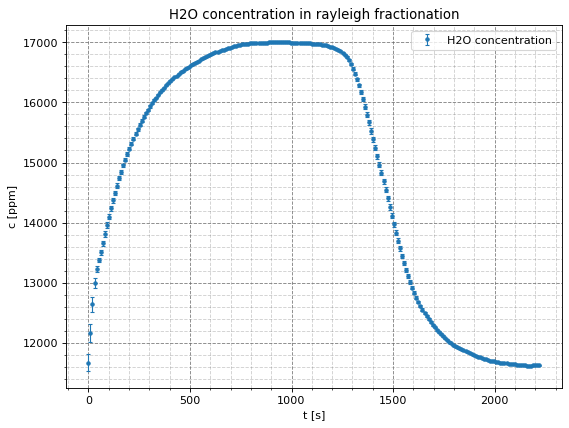

In [46]:
# Defining x axis by calculating delta_t from the beginning of the measurement
t_start = 42960 # seconds, corresponds to 11:56
t_end = 45180 # seconds, corresponds to 12:33
delta_t = t_end - t_start
x = np.linspace(0, delta_t, 221)

plt.figure(figsize=(8, 6), dpi=80)
plt.errorbar(x,H2O_ppm, yerr = H2O_ppm_sd, linestyle='None', marker = ".", label="H2O concentration", capsize = 2, elinewidth=1)
plt.xlabel('t [s]')
plt.ylabel('c [ppm]')
plt.title('H2O concentration in rayleigh fractionation')
#plt.yscale('log')
plt.legend()
plt.grid(b=True, which='major', color='#666666', linestyle='--', alpha = 0.8)
plt.grid(b=True, which='minor', color='#666666', linestyle='--', alpha = 0.3)
plt.minorticks_on()

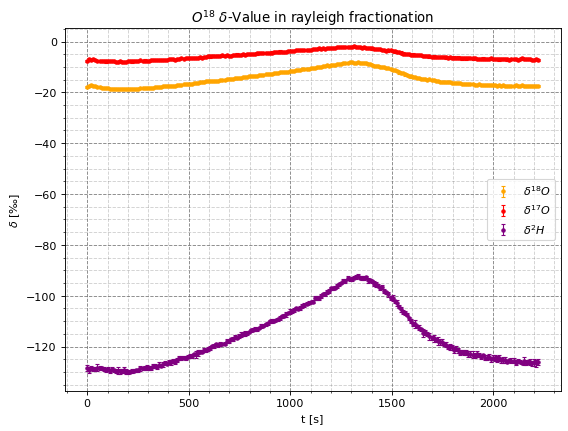

In [72]:
plt.figure(figsize=(8, 6), dpi=80)
plt.errorbar(x,O18_del, yerr = O18_del_sd, linestyle='None', marker = ".", color = "orange", label="$\delta^{18}O$", capsize = 2, elinewidth=1)
plt.errorbar(x,O17_del, yerr = O17_del_sd, linestyle='None', marker = ".", color = "red", label="$\delta^{17}O$", capsize = 2, elinewidth=1)
plt.errorbar(x,D_del, yerr = D_del_sd, linestyle='None', marker = ".", color = "purple", label="$\delta^{2}H$", capsize = 2, elinewidth=1)
plt.xlabel('t [s]')
plt.ylabel('$\delta$ [‰]')
plt.title('$O^{18}$ $\delta$-Value in rayleigh fractionation')
#plt.yscale('log')
plt.legend()
plt.grid(b=True, which='major', color='#666666', linestyle='--', alpha = 0.8)
plt.grid(b=True, which='minor', color='#666666', linestyle='--', alpha = 0.3)
plt.minorticks_on()

# Data extraction for 6.1, 6.3 and 6.4

In [8]:
# Begin with extracting and analyzing the temperature and humidity data
fileloc_testo = os.path.join(dirname, 'Testo Data day 1 and half day 2.txt')

testo_id, testo_T, testo_relhum = np.loadtxt(fileloc_testo, skiprows = 1, usecols = (0, 4, 5), unpack=True, max_rows = 323)

In [9]:
# Calculate mean Temperature and mean relative Humidity
testo_T_mean = np.mean(testo_T)
testo_T_mean_sd = np.std(testo_T)

testo_relhum_mean = np.mean(testo_relhum)
testo_relhum_mean_sd = np.std(testo_relhum)

print("Mean Temperature: T = " , testo_T_mean , "+-" , testo_T_mean_sd , " [°C]")
print("Mean relative Humidity: h = " , testo_relhum_mean , "+-" , testo_relhum_mean_sd , " [%]")

Mean Temperature: T =  23.153560371517028 +- 0.7224901159998725  [°C]
Mean relative Humidity: h =  36.88606811145511 +- 1.7699480555089289  [%]


In [10]:
# Extract the water temperature, rainwater samples and unknown samples data from the text files
fileloc_w1 = os.path.join(dirname, 'tlwia2022-11-21_f0002-Processed.txt')

sample_name = np.loadtxt(fileloc_w1, skiprows=1, usecols=(0), dtype = "str", unpack=True, max_rows=70)
H2O, delta_2H, delta_2H_sd, delta_18O, delta_18O_sd, delta_17O, delta_17O_sd = np.loadtxt(fileloc_w1, skiprows=1, usecols=(1,2,3,4,5,6,7), unpack=True, max_rows=70)

fileloc_w2 = os.path.join(dirname, 'tlwia2022-11-22_f0001-Processed.txt')

sample_name_w2 = np.loadtxt(fileloc_w2, skiprows=1, usecols=(0), dtype = "str", unpack=True, max_rows=79)
H2O_w2, delta_2H_w2, delta_2H_sd_w2, delta_18O_w2, delta_18O_sd_w2, delta_17O_w2, delta_17O_sd_w2 = np.loadtxt(fileloc_w2, skiprows=1, usecols=(1,2,3,4,5,6,7), unpack=True, max_rows=79)
unknown_samples_list = np.array(["W017", "W070", "W071", "K001", "K007"])
rainwater_samples_list = np.array(["603", "641", "102", "105"])

In [11]:
# Now create arrays for the 40 and 50 degree water data
water_40_H2O_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
water_50_H2O_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
water_40_H2O = np.array([0,0,0,0,0,0,0], np.float64)
water_50_H2O = np.array([0,0,0,0,0,0,0], np.float64)
for i in range(sample_name.size):
    if ("40;" in sample_name[i]):
        sample_id = sample_name[i][3:]
        sample_id_int = int(sample_id) - 1
        # print("Sample ID:", sample_id_int + 1)
        if (math.isnan(H2O[i]) == False):
            water_40_H2O_2d[sample_id_int,0] += H2O[i]
            water_40_H2O_2d[sample_id_int,1] += float(1)
            #print("Adding H2O value of ", H2O[i])
            
    if ("50;" in sample_name[i]):
        sample_id = sample_name[i][3:]
        sample_id_int = int(sample_id) - 1
        print("Sample ID:", sample_id_int + 1)
        if (math.isnan(H2O[i]) == False):
            water_50_H2O_2d[sample_id_int,0] += H2O[i]
            water_50_H2O_2d[sample_id_int,1] += float(1)
            
for i in range(water_40_H2O.size):
    if (water_40_H2O_2d[i,1]!=0):
        water_40_H2O[i] = water_40_H2O_2d[i,0]/water_40_H2O_2d[i,1]
    else:
        water_40_H2O[i] = float("nan")
    if (water_50_H2O_2d[i,1]!=0):
        water_50_H2O[i] = water_50_H2O_2d[i,0]/water_50_H2O_2d[i,1]
    else:
        water_50_H2O[i] = float("nan")
print(water_40_H2O)
print(water_50_H2O)

Sample ID: 1
Sample ID: 2
Sample ID: 3
Sample ID: 4
Sample ID: 4
Sample ID: 5
Sample ID: 6
Sample ID: 7
Sample ID: 7
Sample ID: 6
Sample ID: 5
Sample ID: 4
Sample ID: 3
Sample ID: 2
Sample ID: 2
Sample ID: 1
[2.991402e+16 2.920270e+16 2.927615e+16 2.922762e+16 2.971881e+16
 2.935460e+16 2.947921e+16]
[2.9315335e+16 2.9176575e+16 2.9445270e+16 2.9247850e+16 2.9016170e+16
 2.9131000e+16 2.9283575e+16]


In [12]:
# Do the same for delta D values
water_40_delta_2H_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
water_50_delta_2H_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
water_40_delta_2H_sd_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
water_50_delta_2H_sd_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
water_40_delta_2H = np.array([0,0,0,0,0,0,0], np.float64)
water_50_delta_2H = np.array([0,0,0,0,0,0,0], np.float64)
water_40_delta_2H_sd = np.array([0,0,0,0,0,0,0], np.float64)
water_50_delta_2H_sd = np.array([0,0,0,0,0,0,0], np.float64)
for i in range(sample_name.size):
    if ("40;" in sample_name[i]):
        sample_id = sample_name[i][3:]
        sample_id_int = int(sample_id) - 1
        #print("Sample ID:", sample_id_int + 1)
        if ((math.isnan(delta_2H[i]) == False) and (math.isnan(delta_2H_sd[i]) == False)):
            water_40_delta_2H_2d[sample_id_int,0] += delta_2H[i]
            water_40_delta_2H_2d[sample_id_int,1] += float(1)
            
            water_40_delta_2H_sd_2d[sample_id_int,0] += delta_2H_sd[i]**2
            water_40_delta_2H_sd_2d[sample_id_int,1] += float(1)
            
    if ("50;" in sample_name[i]):
        sample_id = sample_name[i][3:]
        sample_id_int = int(sample_id) - 1
        if ((math.isnan(delta_2H[i]) == False) and (math.isnan(delta_2H_sd[i]) == False)):
            water_50_delta_2H_2d[sample_id_int,0] += delta_2H[i]
            water_50_delta_2H_2d[sample_id_int,1] += float(1)
            
            water_50_delta_2H_sd_2d[sample_id_int,0] += delta_2H_sd[i]**2
            water_50_delta_2H_sd_2d[sample_id_int,1] += float(1)
            
for i in range(water_40_delta_2H.size):
    if (water_40_delta_2H_2d[i,1]!=0):
        water_40_delta_2H[i] = water_40_delta_2H_2d[i,0]/water_40_delta_2H_2d[i,1]
    else:
        water_40_delta_2H[i] = float("nan")
    
    if (water_40_delta_2H_sd_2d[i,1]!=0):
        water_40_delta_2H_sd[i] = np.sqrt(water_40_delta_2H_sd_2d[i,0])/water_40_delta_2H_sd_2d[i,1]
    else:
        water_40_delta_2H_sd[i] = float("nan")
    
    if (water_50_delta_2H_2d[i,1]!=0):
        water_50_delta_2H[i] = water_50_delta_2H_2d[i,0]/water_50_delta_2H_2d[i,1]
    else:
        water_50_delta_2H[i] = float("nan")
        
    if (water_50_delta_2H_sd_2d[i,1]!=0):
        water_50_delta_2H_sd[i] = np.sqrt(water_50_delta_2H_sd_2d[i,0])/water_50_delta_2H_sd_2d[i,1]
    else:
        water_50_delta_2H_sd[i] = float("nan")

print(water_40_delta_2H)
print(water_40_delta_2H_sd)
print(water_50_delta_2H)
print(water_50_delta_2H_sd)

[-59.557547  -57.545005  -56.678436  -55.556478  -54.207502  -53.1291515
 -51.5028095]
[0.7929829  0.3874424  0.6098075  0.3140557  0.23587989 0.40872544
 0.34576367]
[-59.051559  -57.1658525 -54.634541  -51.7012825 -49.352494  -46.160142
 -42.982619 ]
[0.34728575 0.361381   0.6266324  0.3420542  0.5180777  0.1637768
 0.43992797]


In [13]:
# Do the same for delta 18O values
water_40_delta_18O_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
water_50_delta_18O_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
water_40_delta_18O_sd_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
water_50_delta_18O_sd_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
water_40_delta_18O = np.array([0,0,0,0,0,0,0], np.float64)
water_50_delta_18O = np.array([0,0,0,0,0,0,0], np.float64)
water_40_delta_18O_sd = np.array([0,0,0,0,0,0,0], np.float64)
water_50_delta_18O_sd = np.array([0,0,0,0,0,0,0], np.float64)
for i in range(sample_name.size):
    if ("40;" in sample_name[i]):
        sample_id = sample_name[i][3:]
        sample_id_int = int(sample_id) - 1
        #print("Sample ID:", sample_id_int + 1)
        if ((math.isnan(delta_18O[i]) == False) and (math.isnan(delta_18O_sd[i]) == False)):
            water_40_delta_18O_2d[sample_id_int,0] += delta_18O[i]
            water_40_delta_18O_2d[sample_id_int,1] += float(1)
            #print("Adding the following O18 value: ", delta_18O[i])
            
            water_40_delta_18O_sd_2d[sample_id_int,0] += delta_18O_sd[i]**2
            water_40_delta_18O_sd_2d[sample_id_int,1] += float(1)
            
    if ("50;" in sample_name[i]):
        sample_id = sample_name[i][3:]
        sample_id_int = int(sample_id) - 1
        if ((math.isnan(delta_18O[i]) == False) and (math.isnan(delta_18O_sd[i]) == False)):
            water_50_delta_18O_2d[sample_id_int,0] += delta_18O[i]
            water_50_delta_18O_2d[sample_id_int,1] += float(1)
            
            water_50_delta_18O_sd_2d[sample_id_int,0] += delta_18O_sd[i]**2
            water_50_delta_18O_sd_2d[sample_id_int,1] += float(1)
            
for i in range(water_40_delta_18O.size):
    if (water_40_delta_18O_2d[i,1]!=0):
        water_40_delta_18O[i] = water_40_delta_18O_2d[i,0]/water_40_delta_18O_2d[i,1]
    else:
        water_40_delta_18O[i] = float("nan")
    
    if (water_40_delta_18O_sd_2d[i,1]!=0):
        water_40_delta_18O_sd[i] = np.sqrt(water_40_delta_18O_sd_2d[i,0])/water_40_delta_18O_sd_2d[i,1]
    else:
        water_40_delta_18O_sd[i] = float("nan")
    
    if (water_50_delta_18O_2d[i,1]!=0):
        water_50_delta_18O[i] = water_50_delta_18O_2d[i,0]/water_50_delta_18O_2d[i,1]
    else:
        water_50_delta_18O[i] = float("nan")
        
    if (water_50_delta_18O_sd_2d[i,1]!=0):
        water_50_delta_18O_sd[i] = np.sqrt(water_50_delta_18O_sd_2d[i,0])/water_50_delta_18O_sd_2d[i,1]
    else:
        water_50_delta_18O_sd[i] = float("nan")

print(water_40_delta_18O)
print(water_40_delta_18O_sd)
print(water_50_delta_18O)
print(water_50_delta_18O_sd)

[-8.331498 -7.592628 -7.359676 -7.358254 -6.763276 -6.64033  -6.226453]
[0.1630297  0.1090298  0.09624214 0.0463301  0.02878096 0.07427974
 0.05249103]
[-8.260712  -7.6875415 -6.846214  -5.9202935 -5.069174  -4.105485
 -3.179445 ]
[0.00821171 0.07354588 0.0671811  0.04849823 0.07198428 0.03253514
 0.0539773 ]


In [14]:
# Do the same for delta 17O values
water_40_delta_17O_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
water_50_delta_17O_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
water_40_delta_17O_sd_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
water_50_delta_17O_sd_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
water_40_delta_17O = np.array([0,0,0,0,0,0,0], np.float64)
water_50_delta_17O = np.array([0,0,0,0,0,0,0], np.float64)
water_40_delta_17O_sd = np.array([0,0,0,0,0,0,0], np.float64)
water_50_delta_17O_sd = np.array([0,0,0,0,0,0,0], np.float64)
for i in range(sample_name.size):
    if ("40;" in sample_name[i]):
        sample_id = sample_name[i][3:]
        sample_id_int = int(sample_id) - 1
        #print("Sample ID:", sample_id_int + 1)
        if ((math.isnan(delta_17O[i]) == False) and (math.isnan(delta_17O_sd[i]) == False)):
            water_40_delta_17O_2d[sample_id_int,0] += delta_17O[i]
            water_40_delta_17O_2d[sample_id_int,1] += float(1)
            print("Adding the following O17 value: ", delta_17O[i])
            
            water_40_delta_17O_sd_2d[sample_id_int,0] += delta_17O_sd[i]**2
            water_40_delta_17O_sd_2d[sample_id_int,1] += float(1)
            
    if ("50;" in sample_name[i]):
        sample_id = sample_name[i][3:]
        sample_id_int = int(sample_id) - 1
        if ((math.isnan(delta_17O[i]) == False) and (math.isnan(delta_17O_sd[i]) == False)):
            water_50_delta_17O_2d[sample_id_int,0] += delta_17O[i]
            water_50_delta_17O_2d[sample_id_int,1] += float(1)
            
            water_50_delta_17O_sd_2d[sample_id_int,0] += delta_17O_sd[i]**2
            water_50_delta_17O_sd_2d[sample_id_int,1] += float(1)
            
for i in range(water_40_delta_17O.size):
    if (water_40_delta_17O_2d[i,1]!=0):
        water_40_delta_17O[i] = water_40_delta_17O_2d[i,0]/water_40_delta_17O_2d[i,1]
    else:
        water_40_delta_17O[i] = float("nan")
    
    if (water_40_delta_17O_sd_2d[i,1]!=0):
        water_40_delta_17O_sd[i] = np.sqrt(water_40_delta_17O_sd_2d[i,0])/water_40_delta_17O_sd_2d[i,1]
    else:
        water_40_delta_17O_sd[i] = float("nan")
    
    if (water_50_delta_17O_2d[i,1]!=0):
        water_50_delta_17O[i] = water_50_delta_17O_2d[i,0]/water_50_delta_17O_2d[i,1]
    else:
        water_50_delta_17O[i] = float("nan")
        
    if (water_50_delta_17O_sd_2d[i,1]!=0):
        water_50_delta_17O_sd[i] = np.sqrt(water_50_delta_17O_sd_2d[i,0])/water_50_delta_17O_sd_2d[i,1]
    else:
        water_50_delta_17O_sd[i] = float("nan")

print(water_40_delta_17O)
print(water_40_delta_17O_sd)
print(water_50_delta_17O)
print(water_50_delta_17O_sd)

Adding the following O17 value:  -4.290802
Adding the following O17 value:  -4.089569
Adding the following O17 value:  -3.628229
Adding the following O17 value:  -3.784332
Adding the following O17 value:  -3.632487
Adding the following O17 value:  -2.915681
Adding the following O17 value:  -3.182254
Adding the following O17 value:  -3.33672
Adding the following O17 value:  -3.574638
Adding the following O17 value:  -4.223756
[-4.223756  -4.290802  -4.089569  -3.574638  -3.4824745 -3.483293
 -3.274084 ]
[0.09018477 0.03196726 0.126879   0.07444796 0.03291298 0.01800505
 0.03204043]
[-4.3073865 -4.0667335 -3.563346  -3.056008  -2.781222  -2.215443
 -1.7271535]
[0.04816567 0.04744622 0.05332622 0.04558966 0.02283007 0.00693411
 0.03898763]


In [15]:
# Now create arrays for the 60 degree water data, as well as for the samples
water_60_H2O_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
water_60_H2O = np.array([0,0,0,0,0,0,0], np.float64)
rainwater_samples_H2O_2d = np.array([[0,0], [0,0], [0,0], [0,0]], np.float64)
rainwater_samples_H2O = np.array([0,0,0,0], np.float64)

unknown_samples_H2O_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
unknown_samples_H2O = np.array([0,0,0,0,0], np.float64)



for i in range(sample_name_w2.size):
    if ("60;" in sample_name_w2[i]):
        sample_id_w2 = sample_name_w2[i][3:]
        sample_id_int_w2 = int(sample_id_w2) - 1
        # print("Sample ID:", sample_id_int_w2 + 1)
        if (math.isnan(H2O_w2[i]) == False):
            water_60_H2O_2d[sample_id_int_w2,0] += H2O_w2[i]
            water_60_H2O_2d[sample_id_int_w2,1] += float(1)
            print("Adding H2O value of ", H2O_w2[i], "to 60deg data at", sample_id_int_w2)
        
    rainwater_sample_id = -1
    if (sample_name_w2[i] in rainwater_samples_list):
        rainwater_sample_id = np.where(rainwater_samples_list == sample_name_w2[i])

    if (math.isnan(H2O_w2[i]) == False and rainwater_sample_id != -1):
        rainwater_samples_H2O_2d[rainwater_sample_id, 0] += H2O_w2[i]
        rainwater_samples_H2O_2d[rainwater_sample_id, 1] += float(1)
        print("Adding H2O value of ", H2O_w2[i], "to rainwater samples data for sample", rainwater_samples_list[rainwater_sample_id])
        
    unknown_sample_id = -1
    if (sample_name_w2[i] in unknown_samples_list):
        unknown_sample_id = np.where(unknown_samples_list == sample_name_w2[i])
        
    if (math.isnan(H2O_w2[i]) == False and unknown_sample_id != -1):
        unknown_samples_H2O_2d[unknown_sample_id, 0] += H2O_w2[i]
        unknown_samples_H2O_2d[unknown_sample_id, 1] += float(1)
        print("Adding H2O value of ", H2O_w2[i], "to unknown samples data for sample", unknown_samples_list[unknown_sample_id])
            
    
            
for i in range(water_60_H2O.size):
    if (water_60_H2O_2d[i,1]!=0):
        water_60_H2O[i] = water_60_H2O_2d[i,0]/water_60_H2O_2d[i,1]
    else:
        water_60_H2O[i] = float("nan")
        
for i in range(rainwater_samples_H2O.size):
    if (rainwater_samples_H2O_2d[i,1]!=0):
        rainwater_samples_H2O[i] = rainwater_samples_H2O_2d[i,0]/rainwater_samples_H2O_2d[i,1]
    else:
        rainwater_samples_H2O[i] = float("nan")
        
for i in range(unknown_samples_H2O.size):
    if (unknown_samples_H2O_2d[i,1]!=0):
        unknown_samples_H2O[i] = unknown_samples_H2O_2d[i,0]/unknown_samples_H2O_2d[i,1]
    else:
        unknown_samples_H2O[i] = float("nan")

print(water_60_H2O)
print(rainwater_samples_H2O)
print(unknown_samples_H2O)

Adding H2O value of  2.889455e+16 to 60deg data at 0
Adding H2O value of  2.864602e+16 to 60deg data at 3
Adding H2O value of  2.90598e+16 to 60deg data at 5
Adding H2O value of  2.896585e+16 to 60deg data at 6
Adding H2O value of  2.905527e+16 to rainwater samples data for sample ['105']
Adding H2O value of  2.898947e+16 to unknown samples data for sample ['W017']
Adding H2O value of  2.914675e+16 to unknown samples data for sample ['W071']
Adding H2O value of  2.896132e+16 to unknown samples data for sample ['K001']
Adding H2O value of  2.90831e+16 to unknown samples data for sample ['K007']
Adding H2O value of  2.898075e+16 to unknown samples data for sample ['K001']
Adding H2O value of  2.898992e+16 to unknown samples data for sample ['W071']
Adding H2O value of  2.902512e+16 to unknown samples data for sample ['W070']
Adding H2O value of  2.89847e+16 to unknown samples data for sample ['W017']
Adding H2O value of  2.906122e+16 to rainwater samples data for sample ['105']
Adding H2

In [16]:
# Equivalent for delta D
water_60_delta_2H_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
water_60_delta_2H = np.array([0,0,0,0,0,0,0], np.float64)
water_60_delta_2H_sd_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
water_60_delta_2H_sd = np.array([0,0,0,0,0,0,0], np.float64)

rainwater_samples_delta_2H_2d = np.array([[0,0], [0,0], [0,0], [0,0]], np.float64)
rainwater_samples_delta_2H = np.array([0,0,0,0], np.float64)
rainwater_samples_delta_2H_sd_2d = np.array([[0,0], [0,0], [0,0], [0,0]], np.float64)
rainwater_samples_delta_2H_sd = np.array([0,0,0,0], np.float64)

unknown_samples_delta_2H_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
unknown_samples_delta_2H = np.array([0,0,0,0,0], np.float64)
unknown_samples_delta_2H_sd_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
unknown_samples_delta_2H_sd = np.array([0,0,0,0,0], np.float64)



for i in range(sample_name_w2.size):
    if ("60;" in sample_name_w2[i]):
        sample_id_w2 = sample_name_w2[i][3:]
        sample_id_int_w2 = int(sample_id_w2) - 1
        # print("Sample ID:", sample_id_int_w2 + 1)
        if (math.isnan(delta_2H_w2[i]) == False and math.isnan(delta_2H_sd_w2[i]) == False):
            water_60_delta_2H_2d[sample_id_int_w2,0] += delta_2H_w2[i]
            water_60_delta_2H_2d[sample_id_int_w2,1] += float(1)
            
            water_60_delta_2H_sd_2d[sample_id_int_w2,0] += delta_2H_sd_w2[i]**2
            water_60_delta_2H_sd_2d[sample_id_int_w2,1] += float(1)
            print("Adding delta 2H value of ", delta_2H_w2[i], "to 60deg data at", sample_id_int_w2)
            print("Adding delta 2H sd value of ", delta_2H_sd_w2[i], "to 60deg data at", sample_id_int_w2)
        
    rainwater_sample_id = -1
    if (sample_name_w2[i] in rainwater_samples_list):
        rainwater_sample_id = np.where(rainwater_samples_list == sample_name_w2[i])

    if (math.isnan(delta_2H_w2[i]) == False and math.isnan(delta_2H_sd_w2[i]) == False and rainwater_sample_id != -1):
        rainwater_samples_delta_2H_2d[rainwater_sample_id, 0] += delta_2H_w2[i]
        rainwater_samples_delta_2H_2d[rainwater_sample_id, 1] += float(1)
        
        rainwater_samples_delta_2H_sd_2d[rainwater_sample_id, 0] += delta_2H_sd_w2[i]**2
        rainwater_samples_delta_2H_sd_2d[rainwater_sample_id, 1] += float(1)
        
        print("Adding delta 2H value of ", delta_2H_w2[i], "to rainwater samples data for sample", rainwater_samples_list[rainwater_sample_id])
        print("Adding delta 2H sd value of ", delta_2H_sd_w2[i], "to rainwater samples data for sample", rainwater_samples_list[rainwater_sample_id])
        
    unknown_sample_id = -1
    if (sample_name_w2[i] in unknown_samples_list):
        unknown_sample_id = np.where(unknown_samples_list == sample_name_w2[i])
        
    if (math.isnan(delta_2H_w2[i]) == False and math.isnan(delta_2H_sd_w2[i]) == False and unknown_sample_id != -1):
        unknown_samples_delta_2H_2d[unknown_sample_id, 0] += delta_2H_w2[i]
        unknown_samples_delta_2H_2d[unknown_sample_id, 1] += float(1)
        
        unknown_samples_delta_2H_sd_2d[unknown_sample_id, 0] += delta_2H_sd_w2[i]**2
        unknown_samples_delta_2H_sd_2d[unknown_sample_id, 1] += float(1)
        print("Adding delta 2H value of ", delta_2H_w2[i], "to unknown samples data for sample", unknown_samples_list[unknown_sample_id])
        print("Adding delta 2H sd value of ", delta_2H_sd_w2[i], "to unknown samples data for sample", unknown_samples_list[unknown_sample_id])
            
    
            
for i in range(water_60_delta_2H.size):
    if (water_60_delta_2H_2d[i,1]!=0):
        water_60_delta_2H[i] = water_60_delta_2H_2d[i,0]/water_60_delta_2H_2d[i,1]
    else:
        water_60_delta_2H[i] = float("nan")
    if (water_60_delta_2H_sd_2d[i,1]!=0):
        water_60_delta_2H_sd[i] = np.sqrt( water_60_delta_2H_sd_2d[i,0] )/water_60_delta_2H_sd_2d[i,1]
    else:
        water_60_delta_2H_sd[i] = float("nan")
        
for i in range(rainwater_samples_delta_2H.size):
    if (rainwater_samples_delta_2H_2d[i,1]!=0):
        rainwater_samples_delta_2H[i] = rainwater_samples_delta_2H_2d[i,0]/rainwater_samples_delta_2H_2d[i,1]
    else:
        rainwater_samples_delta_2H[i] = float("nan")
    if (rainwater_samples_delta_2H_sd_2d[i,1]!=0):
        rainwater_samples_delta_2H_sd[i] = np.sqrt( rainwater_samples_delta_2H_sd_2d[i,0] )/rainwater_samples_delta_2H_sd_2d[i,1]
    else:
        rainwater_samples_delta_2H_sd[i] = float("nan")
        
for i in range(unknown_samples_delta_2H.size):
    if (unknown_samples_delta_2H_2d[i,1]!=0):
        unknown_samples_delta_2H[i] = unknown_samples_delta_2H_2d[i,0]/unknown_samples_delta_2H_2d[i,1]
    else:
        unknown_samples_delta_2H[i] = float("nan")
    if (unknown_samples_delta_2H_sd_2d[i,1]!=0):
        unknown_samples_delta_2H_sd[i] = np.sqrt( unknown_samples_delta_2H_sd_2d[i,0] )/unknown_samples_delta_2H_sd_2d[i,1]
    else:
        unknown_samples_delta_2H_sd[i] = float("nan")

print(water_60_delta_2H)
print(water_60_delta_2H_sd)
print(rainwater_samples_delta_2H)
print(rainwater_samples_delta_2H_sd)
print(unknown_samples_delta_2H)
print(unknown_samples_delta_2H_sd)

Adding delta 2H value of  -58.346711 to 60deg data at 0
Adding delta 2H sd value of  0.5833194 to 60deg data at 0
Adding delta 2H value of  -46.054711 to 60deg data at 3
Adding delta 2H sd value of  0.7497343 to 60deg data at 3
Adding delta 2H value of  -36.327315 to 60deg data at 5
Adding delta 2H sd value of  0.2882997 to 60deg data at 5
Adding delta 2H value of  -28.68804 to 60deg data at 6
Adding delta 2H sd value of  0.4595472 to 60deg data at 6
Adding delta 2H value of  -30.975053 to rainwater samples data for sample ['105']
Adding delta 2H sd value of  0.5524946 to rainwater samples data for sample ['105']
Adding delta 2H value of  -67.403019 to unknown samples data for sample ['W017']
Adding delta 2H sd value of  0.7381354 to unknown samples data for sample ['W017']
Adding delta 2H value of  -30.814329 to unknown samples data for sample ['W071']
Adding delta 2H sd value of  0.7819592 to unknown samples data for sample ['W071']
Adding delta 2H value of  -37.980702 to unknown sam

In [17]:
# Equivalent for delta 18O
water_60_delta_18O_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
water_60_delta_18O = np.array([0,0,0,0,0,0,0], np.float64)
water_60_delta_18O_sd_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
water_60_delta_18O_sd = np.array([0,0,0,0,0,0,0], np.float64)

rainwater_samples_delta_18O_2d = np.array([[0,0], [0,0], [0,0], [0,0]], np.float64)
rainwater_samples_delta_18O = np.array([0,0,0,0], np.float64)
rainwater_samples_delta_18O_sd_2d = np.array([[0,0], [0,0], [0,0], [0,0]], np.float64)
rainwater_samples_delta_18O_sd = np.array([0,0,0,0], np.float64)

unknown_samples_delta_18O_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
unknown_samples_delta_18O = np.array([0,0,0,0,0], np.float64)
unknown_samples_delta_18O_sd_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
unknown_samples_delta_18O_sd = np.array([0,0,0,0,0], np.float64)



for i in range(sample_name_w2.size):
    if ("60;" in sample_name_w2[i]):
        sample_id_w2 = sample_name_w2[i][3:]
        sample_id_int_w2 = int(sample_id_w2) - 1
        # print("Sample ID:", sample_id_int_w2 + 1)
        if (math.isnan(delta_18O_w2[i]) == False and math.isnan(delta_18O_sd_w2[i]) == False):
            water_60_delta_18O_2d[sample_id_int_w2,0] += delta_18O_w2[i]
            water_60_delta_18O_2d[sample_id_int_w2,1] += float(1)
            
            water_60_delta_18O_sd_2d[sample_id_int_w2,0] += delta_18O_sd_w2[i]**2
            water_60_delta_18O_sd_2d[sample_id_int_w2,1] += float(1)
            print("Adding delta 18O value of ", delta_18O_w2[i], "to 60deg data at", sample_id_int_w2)
            print("Adding delta 18O sd value of ", delta_18O_sd_w2[i], "to 60deg data at", sample_id_int_w2)
        
    rainwater_sample_id = -1
    if (sample_name_w2[i] in rainwater_samples_list):
        rainwater_sample_id = np.where(rainwater_samples_list == sample_name_w2[i])

    if (math.isnan(delta_18O_w2[i]) == False and math.isnan(delta_18O_sd_w2[i]) == False and rainwater_sample_id != -1):
        rainwater_samples_delta_18O_2d[rainwater_sample_id, 0] += delta_18O_w2[i]
        rainwater_samples_delta_18O_2d[rainwater_sample_id, 1] += float(1)
        
        rainwater_samples_delta_18O_sd_2d[rainwater_sample_id, 0] += delta_18O_sd_w2[i]**2
        rainwater_samples_delta_18O_sd_2d[rainwater_sample_id, 1] += float(1)
        
        print("Adding delta 18O value of ", delta_18O_w2[i], "to rainwater samples data for sample", rainwater_samples_list[rainwater_sample_id])
        print("Adding delta 18O sd value of ", delta_18O_sd_w2[i], "to rainwater samples data for sample", rainwater_samples_list[rainwater_sample_id])
        
    unknown_sample_id = -1
    if (sample_name_w2[i] in unknown_samples_list):
        unknown_sample_id = np.where(unknown_samples_list == sample_name_w2[i])
        
    if (math.isnan(delta_18O_w2[i]) == False and math.isnan(delta_18O_sd_w2[i]) == False and unknown_sample_id != -1):
        unknown_samples_delta_18O_2d[unknown_sample_id, 0] += delta_18O_w2[i]
        unknown_samples_delta_18O_2d[unknown_sample_id, 1] += float(1)
        
        unknown_samples_delta_18O_sd_2d[unknown_sample_id, 0] += delta_18O_sd_w2[i]**2
        unknown_samples_delta_18O_sd_2d[unknown_sample_id, 1] += float(1)
        print("Adding delta 18O value of ", delta_18O_w2[i], "to unknown samples data for sample", unknown_samples_list[unknown_sample_id])
        print("Adding delta 18O sd value of ", delta_18O_sd_w2[i], "to unknown samples data for sample", unknown_samples_list[unknown_sample_id])
            
    
            
for i in range(water_60_delta_18O.size):
    if (water_60_delta_18O_2d[i,1]!=0):
        water_60_delta_18O[i] = water_60_delta_18O_2d[i,0]/water_60_delta_18O_2d[i,1]
    else:
        water_60_delta_18O[i] = float("nan")
    if (water_60_delta_18O_sd_2d[i,1]!=0):
        water_60_delta_18O_sd[i] = np.sqrt( water_60_delta_18O_sd_2d[i,0] )/water_60_delta_18O_sd_2d[i,1]
    else:
        water_60_delta_18O_sd[i] = float("nan")
        
for i in range(rainwater_samples_delta_18O.size):
    if (rainwater_samples_delta_18O_2d[i,1]!=0):
        rainwater_samples_delta_18O[i] = rainwater_samples_delta_18O_2d[i,0]/rainwater_samples_delta_18O_2d[i,1]
    else:
        rainwater_samples_delta_18O[i] = float("nan")
    if (rainwater_samples_delta_18O_sd_2d[i,1]!=0):
        rainwater_samples_delta_18O_sd[i] = np.sqrt( rainwater_samples_delta_18O_sd_2d[i,0] )/rainwater_samples_delta_18O_sd_2d[i,1]
    else:
        rainwater_samples_delta_18O_sd[i] = float("nan")
        
for i in range(unknown_samples_delta_18O.size):
    if (unknown_samples_delta_18O_2d[i,1]!=0):
        unknown_samples_delta_18O[i] = unknown_samples_delta_18O_2d[i,0]/unknown_samples_delta_18O_2d[i,1]
    else:
        unknown_samples_delta_18O[i] = float("nan")
    if (unknown_samples_delta_18O_sd_2d[i,1]!=0):
        unknown_samples_delta_18O_sd[i] = np.sqrt( unknown_samples_delta_18O_sd_2d[i,0] )/unknown_samples_delta_18O_sd_2d[i,1]
    else:
        unknown_samples_delta_18O_sd[i] = float("nan")

print(water_60_delta_18O)
print(water_60_delta_18O_sd)
print(rainwater_samples_delta_18O)
print(rainwater_samples_delta_18O_sd)
print(unknown_samples_delta_18O)
print(unknown_samples_delta_18O_sd)

Adding delta 18O value of  -7.962762 to 60deg data at 0
Adding delta 18O sd value of  0.07469079 to 60deg data at 0
Adding delta 18O value of  -3.892779 to 60deg data at 3
Adding delta 18O sd value of  0.1172496 to 60deg data at 3
Adding delta 18O value of  -0.57423 to 60deg data at 5
Adding delta 18O sd value of  0.07182625 to 60deg data at 5
Adding delta 18O value of  1.933134 to 60deg data at 6
Adding delta 18O sd value of  0.09152789 to 60deg data at 6
Adding delta 18O value of  -5.174753 to rainwater samples data for sample ['105']
Adding delta 18O sd value of  0.06788711 to rainwater samples data for sample ['105']
Adding delta 18O value of  -9.76156 to unknown samples data for sample ['W017']
Adding delta 18O sd value of  0.08460943 to unknown samples data for sample ['W017']
Adding delta 18O value of  -5.641661 to unknown samples data for sample ['W071']
Adding delta 18O sd value of  0.06468981 to unknown samples data for sample ['W071']
Adding delta 18O value of  -6.884413 to 

In [18]:
# Equivalent for delta 17O
water_60_delta_17O_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
water_60_delta_17O = np.array([0,0,0,0,0,0,0], np.float64)
water_60_delta_17O_sd_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
water_60_delta_17O_sd = np.array([0,0,0,0,0,0,0], np.float64)

rainwater_samples_delta_17O_2d = np.array([[0,0], [0,0], [0,0], [0,0]], np.float64)
rainwater_samples_delta_17O = np.array([0,0,0,0], np.float64)
rainwater_samples_delta_17O_sd_2d = np.array([[0,0], [0,0], [0,0], [0,0]], np.float64)
rainwater_samples_delta_17O_sd = np.array([0,0,0,0], np.float64)

unknown_samples_delta_17O_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
unknown_samples_delta_17O = np.array([0,0,0,0,0], np.float64)
unknown_samples_delta_17O_sd_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
unknown_samples_delta_17O_sd = np.array([0,0,0,0,0], np.float64)



for i in range(sample_name_w2.size):
    if ("60;" in sample_name_w2[i]):
        sample_id_w2 = sample_name_w2[i][3:]
        sample_id_int_w2 = int(sample_id_w2) - 1
        # print("Sample ID:", sample_id_int_w2 + 1)
        if (math.isnan(delta_17O_w2[i]) == False and math.isnan(delta_17O_sd_w2[i]) == False):
            water_60_delta_17O_2d[sample_id_int_w2,0] += delta_17O_w2[i]
            water_60_delta_17O_2d[sample_id_int_w2,1] += float(1)
            
            water_60_delta_17O_sd_2d[sample_id_int_w2,0] += delta_17O_sd_w2[i]**2
            water_60_delta_17O_sd_2d[sample_id_int_w2,1] += float(1)
            print("Adding delta 17O value of ", delta_17O_w2[i], "to 60deg data at", sample_id_int_w2)
            print("Adding delta 17O sd value of ", delta_17O_sd_w2[i], "to 60deg data at", sample_id_int_w2)
        
    rainwater_sample_id = -1
    if (sample_name_w2[i] in rainwater_samples_list):
        rainwater_sample_id = np.where(rainwater_samples_list == sample_name_w2[i])

    if (math.isnan(delta_17O_w2[i]) == False and math.isnan(delta_17O_sd_w2[i]) == False and rainwater_sample_id != -1):
        rainwater_samples_delta_17O_2d[rainwater_sample_id, 0] += delta_17O_w2[i]
        rainwater_samples_delta_17O_2d[rainwater_sample_id, 1] += float(1)
        
        rainwater_samples_delta_17O_sd_2d[rainwater_sample_id, 0] += delta_17O_sd_w2[i]**2
        rainwater_samples_delta_17O_sd_2d[rainwater_sample_id, 1] += float(1)
        
        print("Adding delta 17O value of ", delta_17O_w2[i], "to rainwater samples data for sample", rainwater_samples_list[rainwater_sample_id])
        print("Adding delta 17O sd value of ", delta_17O_sd_w2[i], "to rainwater samples data for sample", rainwater_samples_list[rainwater_sample_id])
        
    unknown_sample_id = -1
    if (sample_name_w2[i] in unknown_samples_list):
        unknown_sample_id = np.where(unknown_samples_list == sample_name_w2[i])
        
    if (math.isnan(delta_17O_w2[i]) == False and math.isnan(delta_17O_sd_w2[i]) == False and unknown_sample_id != -1):
        unknown_samples_delta_17O_2d[unknown_sample_id, 0] += delta_17O_w2[i]
        unknown_samples_delta_17O_2d[unknown_sample_id, 1] += float(1)
        
        unknown_samples_delta_17O_sd_2d[unknown_sample_id, 0] += delta_17O_sd_w2[i]**2
        unknown_samples_delta_17O_sd_2d[unknown_sample_id, 1] += float(1)
        print("Adding delta 17O value of ", delta_17O_w2[i], "to unknown samples data for sample", unknown_samples_list[unknown_sample_id])
        print("Adding delta 17O sd value of ", delta_17O_sd_w2[i], "to unknown samples data for sample", unknown_samples_list[unknown_sample_id])
            
    
            
for i in range(water_60_delta_17O.size):
    if (water_60_delta_17O_2d[i,1]!=0):
        water_60_delta_17O[i] = water_60_delta_17O_2d[i,0]/water_60_delta_17O_2d[i,1]
    else:
        water_60_delta_17O[i] = float("nan")
    if (water_60_delta_17O_sd_2d[i,1]!=0):
        water_60_delta_17O_sd[i] = np.sqrt( water_60_delta_17O_sd_2d[i,0] )/water_60_delta_17O_sd_2d[i,1]
    else:
        water_60_delta_17O_sd[i] = float("nan")
        
for i in range(rainwater_samples_delta_17O.size):
    if (rainwater_samples_delta_17O_2d[i,1]!=0):
        rainwater_samples_delta_17O[i] = rainwater_samples_delta_17O_2d[i,0]/rainwater_samples_delta_17O_2d[i,1]
    else:
        rainwater_samples_delta_17O[i] = float("nan")
    if (rainwater_samples_delta_17O_sd_2d[i,1]!=0):
        rainwater_samples_delta_17O_sd[i] = np.sqrt( rainwater_samples_delta_17O_sd_2d[i,0] )/rainwater_samples_delta_17O_sd_2d[i,1]
    else:
        rainwater_samples_delta_17O_sd[i] = float("nan")
        
for i in range(unknown_samples_delta_17O.size):
    if (unknown_samples_delta_17O_2d[i,1]!=0):
        unknown_samples_delta_17O[i] = unknown_samples_delta_17O_2d[i,0]/unknown_samples_delta_17O_2d[i,1]
    else:
        unknown_samples_delta_17O[i] = float("nan")
    if (unknown_samples_delta_17O_sd_2d[i,1]!=0):
        unknown_samples_delta_17O_sd[i] = np.sqrt( unknown_samples_delta_17O_sd_2d[i,0] )/unknown_samples_delta_17O_sd_2d[i,1]
    else:
        unknown_samples_delta_17O_sd[i] = float("nan")

print(water_60_delta_17O)
print(water_60_delta_17O_sd)
print(rainwater_samples_delta_17O)
print(rainwater_samples_delta_17O_sd)
print(unknown_samples_delta_17O)
print(unknown_samples_delta_17O_sd)

Adding delta 17O value of  -4.25176 to 60deg data at 0
Adding delta 17O sd value of  0.05840377 to 60deg data at 0
Adding delta 17O value of  -2.270856 to 60deg data at 3
Adding delta 17O sd value of  0.09428137 to 60deg data at 3
Adding delta 17O value of  -0.29519 to 60deg data at 5
Adding delta 17O sd value of  0.04159646 to 60deg data at 5
Adding delta 17O value of  0.980165 to 60deg data at 6
Adding delta 17O sd value of  0.06599527 to 60deg data at 6
Adding delta 17O value of  -2.92845 to rainwater samples data for sample ['105']
Adding delta 17O sd value of  0.08127778 to rainwater samples data for sample ['105']
Adding delta 17O value of  -5.289942 to unknown samples data for sample ['W017']
Adding delta 17O sd value of  0.08053391 to unknown samples data for sample ['W017']
Adding delta 17O value of  -2.912805 to unknown samples data for sample ['W071']
Adding delta 17O sd value of  0.1001621 to unknown samples data for sample ['W071']
Adding delta 17O value of  -3.509649 to u

# 6.1 Evaporation at Different Water Temperatures

In [19]:
# Measured Masses:
m_W_40 = (np.array([958.3,947.4,936.4,924.4,914.6,902.2,890.6])-426.8)/538.3
m_W_50 = (np.array([950.4,929.8,909.4,885.6,865.3,842.3,819.7])-421.9)/539.3
m_W_60 = (np.array([941.9,906.9,870.0,832.4,794.0,757.5,711.7])-421.9)/539.8

In [62]:
# Define fit function (Rayleigh Fractionation)
def rayleigh(Nfrac, alpha, delta_0):
    return (1 + delta_0)*(Nfrac)**(alpha - 1) - 1

Frac Factor 2H: 0.9428147030554458 +- 0.002439539639381871
Frac Factor 18O: 0.9861885182441825 +- 0.0021190656357157256
Frac Factor 17O: 0.9917728944882523 +- 0.0011019402091731873


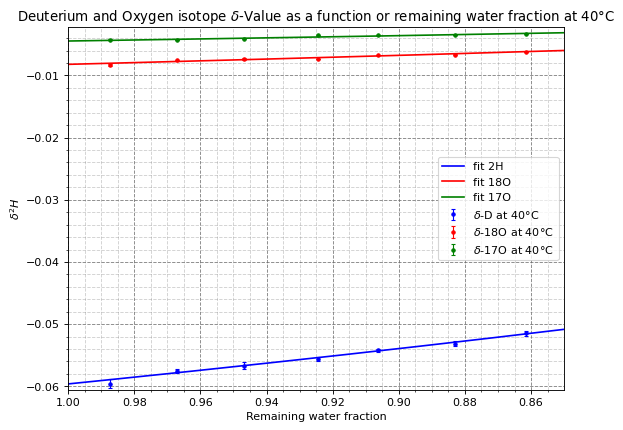

In [75]:
popt_w40_2H, pcov_w40_2H = curve_fit(rayleigh, m_W_40, water_40_delta_2H * 10**(-3), sigma = water_40_delta_2H_sd * 10**(-3))
x_w40_2H = np.linspace(0.85, 1, 1000)

popt_w40_18O, pcov_w40_18O = curve_fit(rayleigh, m_W_40, water_40_delta_18O * 10**(-3), sigma = water_40_delta_18O_sd * 10**(-3))
x_w40_18O = np.linspace(0.85, 1, 1000)

popt_w40_17O, pcov_w40_17O = curve_fit(rayleigh, m_W_40, water_40_delta_17O * 10**(-3), sigma = water_40_delta_17O_sd * 10**(-3))
x_w40_17O = np.linspace(0.85, 1, 1000)

plt.figure(figsize=(8, 6), dpi=80)
plt.errorbar(m_W_40,water_40_delta_2H * 10**(-3), yerr = water_40_delta_2H_sd * 10**(-3), linestyle='None', marker = ".", color = "blue", label="$\delta$-D at 40°C", capsize = 2, elinewidth=1)
plt.plot(x_w40_2H, rayleigh(x_w40_2H, *popt_w40_2H), label="fit 2H", color = "blue")
plt.errorbar(m_W_40,water_40_delta_18O * 10**(-3), yerr = water_40_delta_18O_sd * 10**(-3), linestyle='None', marker = ".", color = "red", label="$\delta$-18O at 40°C", capsize = 2, elinewidth=1)
plt.plot(x_w40_18O, rayleigh(x_w40_18O, *popt_w40_18O), label="fit 18O", color = "red")
plt.errorbar(m_W_40,water_40_delta_17O * 10**(-3), yerr = water_40_delta_17O_sd * 10**(-3), linestyle='None', marker = ".", color = "green", label="$\delta$-17O at 40°C", capsize = 2, elinewidth=1)
plt.plot(x_w40_17O, rayleigh(x_w40_17O, *popt_w40_17O), label="fit 17O", color = "green")
plt.xlabel('Remaining water fraction')
plt.ylabel('$\delta^{2}H$')
plt.title('Deuterium and Oxygen isotope $\delta$-Value as a function or remaining water fraction at 40°C')
#plt.yscale('log')
plt.axis([1, 0.85, min(water_40_delta_2H * 10**(-3)) - 0.001, max(water_40_delta_17O * 10**(-3)) + 0.001])
plt.legend()
plt.grid(b=True, which='major', color='#666666', linestyle='--', alpha = 0.8)
plt.grid(b=True, which='minor', color='#666666', linestyle='--', alpha = 0.3)
plt.minorticks_on()

print("Frac Factor 2H:", popt_w40_2H[0], "+-", np.sqrt(pcov_w40_2H[0,0]))
print("Frac Factor 18O:", popt_w40_18O[0], "+-", np.sqrt(pcov_w40_18O[0,0]))
print("Frac Factor 17O:", popt_w40_17O[0], "+-", np.sqrt(pcov_w40_17O[0,0]))

Frac Factor: 0.9398683326295303 +- 0.000495548192602561
Frac Factor: 0.9818453570304363 +- 0.00011955841318854921
Frac Factor: 0.990601016575072 +- 0.0002461707332265111


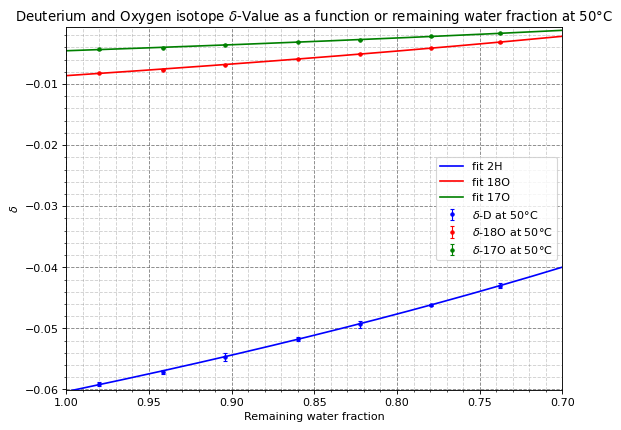

In [76]:
popt_w50_2H, pcov_w50_2H = curve_fit(rayleigh, m_W_50, water_50_delta_2H * 10**(-3), sigma = water_50_delta_2H_sd * 10**(-3))
x_w50_2H = np.linspace(0.7, 1, 1000)

popt_w50_18O, pcov_w50_18O = curve_fit(rayleigh, m_W_50, water_50_delta_18O * 10**(-3), sigma = water_50_delta_18O_sd * 10**(-3))
x_w50_18O = np.linspace(0.7, 1, 1000)

popt_w50_17O, pcov_w50_17O = curve_fit(rayleigh, m_W_50, water_50_delta_17O * 10**(-3), sigma = water_50_delta_17O_sd * 10**(-3))
x_w50_17O = np.linspace(0.7, 1, 1000)

plt.figure(figsize=(8, 6), dpi=80)
plt.errorbar(m_W_50,water_50_delta_2H * 10**(-3), yerr = water_50_delta_2H_sd * 10**(-3), linestyle='None', marker = ".", color = "blue", label="$\delta$-D at 50°C", capsize = 2, elinewidth=1)
plt.plot(x_w50_2H, rayleigh(x_w50_2H, *popt_w50_2H), label="fit 2H", color = "blue")
plt.errorbar(m_W_50,water_50_delta_18O * 10**(-3), yerr = water_50_delta_18O_sd * 10**(-3), linestyle='None', marker = ".", color = "red", label="$\delta$-18O at 50°C", capsize = 2, elinewidth=1)
plt.plot(x_w50_18O, rayleigh(x_w50_18O, *popt_w50_18O), label="fit 18O", color = "red")
plt.errorbar(m_W_50,water_50_delta_17O * 10**(-3), yerr = water_50_delta_17O_sd * 10**(-3), linestyle='None', marker = ".", color = "green", label="$\delta$-17O at 50°C", capsize = 2, elinewidth=1)
plt.plot(x_w50_17O, rayleigh(x_w50_17O, *popt_w50_17O), label="fit 17O", color = "green")
plt.xlabel('Remaining water fraction')
plt.ylabel('$\delta$')
plt.title('Deuterium and Oxygen isotope $\delta$-Value as a function or remaining water fraction at 50°C')
#plt.yscale('log')
plt.axis([1, 0.7, min(water_50_delta_2H * 10**(-3)) - 0.001, max(water_50_delta_17O * 10**(-3)) + 0.001])
plt.legend()
plt.grid(b=True, which='major', color='#666666', linestyle='--', alpha = 0.8)
plt.grid(b=True, which='minor', color='#666666', linestyle='--', alpha = 0.3)
plt.minorticks_on()

print("Frac Factor:", popt_w50_2H[0], "+-", np.sqrt(pcov_w50_2H[0,0]))
print("Frac Factor:", popt_w50_18O[0], "+-", np.sqrt(pcov_w50_18O[0,0]))
print("Frac Factor:", popt_w50_17O[0], "+-", np.sqrt(pcov_w50_17O[0,0]))

Frac Factor 2H: 0.9464786578448088 +- 0.00029577710686033855
Frac Factor O18: 0.9839469738180193 +- 0.0004981937851346043
Frac Factor O17: 0.9922708140310372 +- 0.0006658038886227538


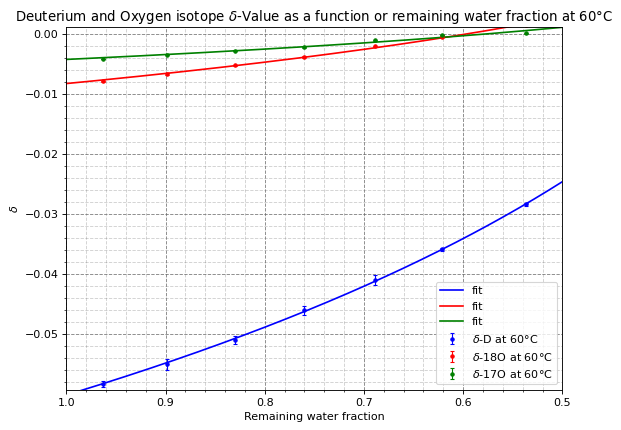

In [79]:
popt_w60_2H, pcov_w60_2H = curve_fit(rayleigh, m_W_60, water_60_delta_2H * 10**(-3), sigma = water_60_delta_2H_sd * 10**(-3))
x_w60_2H = np.linspace(0.5, 1, 1000)

popt_w60_18O, pcov_w60_18O = curve_fit(rayleigh, m_W_60, water_60_delta_18O * 10**(-3), sigma = water_60_delta_18O_sd * 10**(-3))
x_w60_18O = np.linspace(0.5, 1, 1000)

popt_w60_17O, pcov_w60_17O = curve_fit(rayleigh, m_W_60, water_60_delta_17O * 10**(-3), sigma = water_60_delta_17O_sd * 10**(-3))
x_w60_17O = np.linspace(0.5, 1, 1000)

plt.figure(figsize=(8, 6), dpi=80)
plt.errorbar(m_W_60,water_60_delta_2H * 10**(-3), yerr = water_60_delta_2H_sd * 10**(-3), linestyle='None', marker = ".", color = "blue", label="$\delta$-D at 60°C", capsize = 2, elinewidth=1)
plt.plot(x_w60_2H, rayleigh(x_w60_2H, *popt_w60_2H), label="fit", color = "blue")
plt.errorbar(m_W_60,water_60_delta_18O * 10**(-3), yerr = water_60_delta_18O_sd * 10**(-3), linestyle='None', marker = ".", color = "red", label="$\delta$-18O at 60°C", capsize = 2, elinewidth=1)
plt.plot(x_w60_18O, rayleigh(x_w60_18O, *popt_w60_18O), label="fit", color = "red")
plt.errorbar(m_W_60,water_60_delta_17O * 10**(-3), yerr = water_60_delta_17O_sd * 10**(-3), linestyle='None', marker = ".", color = "green", label="$\delta$-17O at 60°C", capsize = 2, elinewidth=1)
plt.plot(x_w60_17O, rayleigh(x_w60_17O, *popt_w60_17O), label="fit", color = "green")
plt.xlabel('Remaining water fraction')
plt.ylabel('$\delta$')
plt.title('Deuterium and Oxygen isotope $\delta$-Value as a function or remaining water fraction at 60°C')
#plt.yscale('log')
plt.axis([1, 0.5, min(water_60_delta_2H * 10**(-3)) - 0.001, max(water_60_delta_17O * 10**(-3)) + 0.001])
plt.legend()
plt.grid(b=True, which='major', color='#666666', linestyle='--', alpha = 0.8)
plt.grid(b=True, which='minor', color='#666666', linestyle='--', alpha = 0.3)
plt.minorticks_on()

print("Frac Factor 2H:", popt_w60_2H[0], "+-", np.sqrt(pcov_w60_2H[0,0]))
print("Frac Factor O18:", popt_w60_18O[0], "+-", np.sqrt(pcov_w60_18O[0,0]))
print("Frac Factor O17:", popt_w60_17O[0], "+-", np.sqrt(pcov_w60_17O[0,0]))

In [81]:
# Water lines:
def linear(x, a, b):
    return a*x + b

water_all_delta_2H = np.concatenate((water_40_delta_2H, water_50_delta_2H, water_60_delta_2H))
water_all_delta_2H_sd = np.concatenate((water_40_delta_2H_sd, water_50_delta_2H_sd, water_60_delta_2H_sd))
water_all_delta_18O = np.concatenate((water_40_delta_18O, water_50_delta_18O, water_60_delta_18O))
water_all_delta_18O_sd = np.concatenate((water_40_delta_18O_sd, water_50_delta_18O_sd, water_60_delta_18O_sd))

Water Line slope:  3.0435349865313963 +- 0.04436623816121609
Deviation:  111.71704473699164


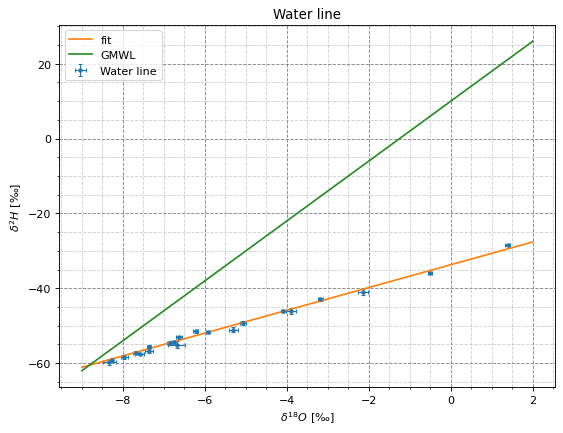

In [86]:
popt_wlall, pcov_wlall = curve_fit(linear, water_all_delta_18O, water_all_delta_2H, sigma = water_all_delta_2H_sd)
x_wlall = np.linspace(-9, 2, 1000)

plt.figure(figsize=(8, 6), dpi=80)
plt.errorbar(water_all_delta_18O, water_all_delta_2H, xerr = water_all_delta_18O_sd, yerr = water_all_delta_2H_sd, linestyle='None', marker = ".", label="Water line", capsize = 2, elinewidth=1)
plt.plot(x_wlall, linear(x_wlall, *popt_wlall), label="fit")
plt.plot(x_wlall, linear(x_wlall, 8, 10), label = "GMWL", color="forestgreen")
plt.xlabel('$\delta^{18}O$ [‰]')
plt.ylabel('$\delta^{2}H$ [‰]')
plt.title('Water line')
#plt.yscale('log')
plt.legend()
plt.grid(b=True, which='major', color='#666666', linestyle='--', alpha = 0.8)
plt.grid(b=True, which='minor', color='#666666', linestyle='--', alpha = 0.3)
plt.minorticks_on()

# Deviation from water line slope
wl_slope_lit = 8
sigma_wlall = np.abs((wl_slope_lit - popt_wlall[0])/np.sqrt(pcov_wlall[0,0]))

print("Water Line slope: ", popt_wlall[0], "+-", np.sqrt(pcov_wlall[0,0]))
print("Deviation: ", sigma_wlall)

Water Line slope 50°C:  3.1047698499275747 +- 0.02642720324387294
Deviation:  185.23451403081665


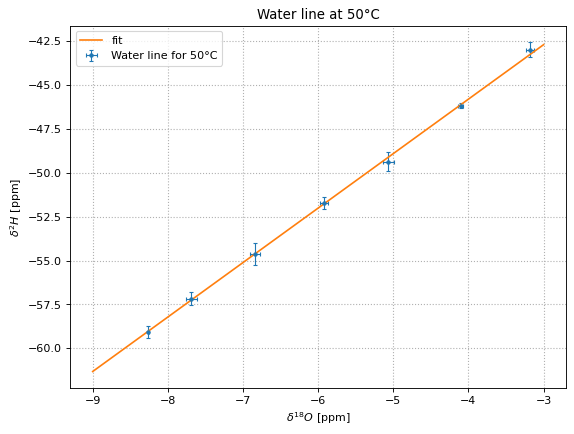

In [32]:
popt_wl50, pcov_wl50 = curve_fit(linear, water_50_delta_18O, water_50_delta_2H, sigma = water_50_delta_2H_sd)
x_wl50 = np.linspace(-9, -3, 1000)

plt.figure(figsize=(8, 6), dpi=80)
plt.errorbar(water_50_delta_18O, water_50_delta_2H, xerr = water_50_delta_18O_sd, yerr = water_50_delta_2H_sd, linestyle='None', marker = ".", label="Water line for 50°C", capsize = 2, elinewidth=1)
plt.plot(x_wl50, linear(x_wl50, *popt_wl50), label="fit")
plt.xlabel('$\delta^{18}O$ [ppm]')
plt.ylabel('$\delta^{2}H$ [ppm]')
plt.title('Water line at 50°C')
#plt.yscale('log')
plt.legend()
plt.grid(linestyle=":", linewidth=1)

wl_slope_lit = 8
sigma_wl50 = np.abs((wl_slope_lit - popt_wl50[0])/np.sqrt(pcov_wl50[0,0]))

print("Water Line slope 50°C: ", popt_wl50[0], "+-", np.sqrt(pcov_wl50[0,0]))
print("Deviation: ", sigma_wl50)

Water Line slope 60°C:  3.1827920732939643 +- 0.10915956583305386
Deviation:  44.12996598093257


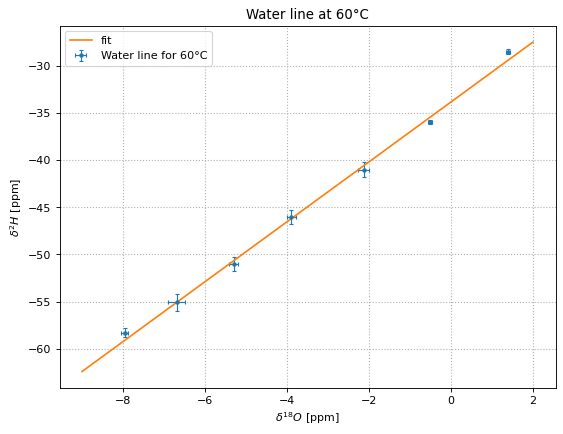

In [33]:
popt_wl60, pcov_wl60 = curve_fit(linear, water_60_delta_18O, water_60_delta_2H, sigma = water_60_delta_2H_sd)
x_wl60 = np.linspace(-9, 2, 1000)

plt.figure(figsize=(8, 6), dpi=80)
plt.errorbar(water_60_delta_18O, water_60_delta_2H, xerr = water_60_delta_18O_sd, yerr = water_60_delta_2H_sd, linestyle='None', marker = ".", label="Water line for 60°C", capsize = 2, elinewidth=1)
plt.plot(x_wl60, linear(x_wl60, *popt_wl60), label="fit")
plt.xlabel('$\delta^{18}O$ [ppm]')
plt.ylabel('$\delta^{2}H$ [ppm]')
plt.title('Water line at 60°C')
#plt.yscale('log')
plt.legend()
plt.grid(linestyle=":", linewidth=1)

wl_slope_lit = 8
sigma_wl60 = np.abs((wl_slope_lit - popt_wl60[0])/np.sqrt(pcov_wl60[0,0]))

print("Water Line slope 60°C: ", popt_wl60[0], "+-", np.sqrt(pcov_wl60[0,0]))
print("Deviation: ", sigma_wl60)

In [34]:
# TODO: alpha factors

# 6.4 Finding the source of unknown samples

In [35]:
# Once again print the final measured values:


for i in range(unknown_samples_list.size):
    print(unknown_samples_list[i], ":")
    print("d2H = ", unknown_samples_delta_2H[i], "+-", unknown_samples_delta_2H_sd[i])
    print("d18O = ", unknown_samples_delta_18O[i], "+-", unknown_samples_delta_18O_sd[i])
    print("d17O = ", unknown_samples_delta_17O[i], "+-", unknown_samples_delta_17O_sd[i])

W017 :
d2H =  -67.341215 +- 0.44376378023260304
d18O =  -9.7936065 +- 0.06323187243094122
d17O =  -5.1209415 +- 0.05018128071977688
W070 :
d2H =  -29.952336 +- 0.6395154
d18O =  -5.322863 +- 0.119458
d17O =  -2.659701 +- 0.02975414
W071 :
d2H =  -31.00985 +- 0.40947886874349204
d18O =  -5.5768015 +- 0.051025164580932515
d17O =  -2.8248485 +- 0.06205312973510765
K001 :
d2H =  -38.061883 +- 0.26001882000059634
d18O =  -6.8601035 +- 0.029549800117781258
d17O =  -3.47078 +- 0.04356654462328433
K007 :
d2H =  -41.6421785 +- 0.4182432619259903
d18O =  -4.734077 +- 0.05635897782102865
d17O =  -2.480701 +- 0.05061391757526407


In [36]:
# Analysis: which samples could be which
# W017 could be Puslinch (-67.484, -9.839, -5.231)
# or could be Bad Liebenwerda (-66.746, -9.803, -5.159)
# or could be Wiesenburg (-66.302, 9.467, -5.178)
# or maybe could be Xi'an (-68.321, -10.208, -5.405)
# or could be Marianskych (-67.841, -9.408, -5.241)
# tending towards Bad Liebenwerda

# W070 could be Roxane, Benton (-32.132. -5.491, -3)
# or could be Serra do Buaco (-27.959, -5.125, -2.7)
# or could be Serra do Geras (-30.636, -5.456, -2.897)
# or could be Serra de Sao Mamede (-31.654, -5.649, -3.032)
# or could be Merida (-29.546, -5.009, -2.664) # but is european
# so maybe Serra do Geras? but that's W071

# W071 could be similar to W070
# tending towards Serra do Geras

# K001 is non-european
# K001 could be Crete (-37.961, -7.193, -3.798)
# or could be Julatten (-37.655, -6.393, -3.465)
# or could be Dubrovnik (-39.59, -6.689, -3.701)
# is non-european so probably Julatten

# K007 could be Katzenbuckel (-41.715, -4.665, -2.506)

# General trends:
# futher from coast -> lighter, continental effect, has travelled longer distance
# --> more of the heavier isotopes have been carried away by rain

# higher altitude --> lighter, because colder

# 6.3 Local Rainwater Samples

In [37]:
fileloc_rw_individual = os.path.join(dirname, 'Rainwater_Samples_Individual.csv')
fileloc_rw_means = os.path.join(dirname, 'Rainwater_Samples_Means.csv')

df_rw_individual = pd.read_csv(fileloc_rw_individual, delimiter=";", nrows=385)
df_rw_means = pd.read_csv(fileloc_rw_means, delimiter=";", nrows=70)

rw_individual_probe_id = df_rw_individual['Probennummer'].to_numpy()
rw_means_probe_id = df_rw_means["Sample Name"].to_numpy()
print(rw_individual_probe_id)
print(rw_means_probe_id)

# Rainwater samples timeframes:
# 641: 18.-21.11.2022
# 603: 29.4. - 3.5.2022
# 105: 4.10. - 2.11.2022
# 102: 29.6. - 2.8.2022

for i in range(rainwater_samples_list.size):
    print(rainwater_samples_list[i], ":")
    print("d2H = ", rainwater_samples_delta_2H[i], "+-", rainwater_samples_delta_2H_sd[i])
    print("d18O = ", rainwater_samples_delta_18O[i], "+-", rainwater_samples_delta_18O_sd[i])
    print("d17O = ", rainwater_samples_delta_17O[i], "+-", rainwater_samples_delta_17O_sd[i])

[114 115 116 117 118 119 120 122 123 124 125 126 127 128 129 130 131 132
 133 134 135 136 137 138 139 140 141 142 143 145 146 147 148 149 150 151
 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169
 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187
 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205
 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223
 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241
 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 260
 263 264 265 266 267 268 270 271 272 273 274 275 276 280 283 285 286 290
 292 293 295 296 297 298 300 301 302 303 305 308 310 311 312 313 314 316
 317 319 320 323 327 328 329 330 331 333 335 336 337 338 339 341 342 343
 344 345 346 347 348 349 350 353 354 355 356 357 359 360 361 364 366 367
 368 369 373 377 378 379 380 381 382 383 384 385 386 388 389 390 393 394
 395 396 399 401 402 404 405 406 407 408 409 410 41